In [1]:
import numpy as np
from sklearn import datasets
from collections import OrderedDict
from scipy.stats import truncnorm


## 中間層レイヤ定義

In [2]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        #重み、バイアスパラメータの微分
        self.dW = None
        self.db = None
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

class Relu:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx
  


## 誤差関数とその導関数

In [3]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(d, y):
    """
    CrossEntropyを取得します。
    (今回の問題ではlabel=indexなので、d * log(y)は、log(y)のd列要素を取り出すだけ)
    """
    batch_size = y.shape[0]
    #print("arange:", np.arange(batch_size).shape)
    #print("d_shape:", d.shape)
    #print("d:", d)
    #print("arange_y_shape:", y[np.arange(batch_size), d].shape)
    #print("arange_y:", y[np.arange(batch_size), d])
    #print("ce_head:", np.log(y[np.arange(batch_size), d] + 1e-7)[0])
    return -np.sum(np.log(y[np.arange(batch_size), d] + 1e-15)) / batch_size

def d_SoftmaxWithLoss(d, y):
    """
    SoftmaxとCrossEntropyを合わせた勾配を取得します
    """
    batch_size = d.shape[0]
    if d.size == y.size: # 教師データがone-hot-vectorの場合
        dx = (y - d) / batch_size
    else:
        dx = y.copy()
        dx[np.arange(batch_size), d] -= 1
        dx = dx / batch_size

    return dx


## その他の関数

In [4]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch


def accuracy(d, y):
    """
    正解率
    """
    test_size = d.shape[0]
    return (d == y).astype(np.int32).sum() / test_size


## 自前ニューラルネットワーク

In [5]:
class my_mnist_nn:
    
    def __init__(self, hidden1_nodes, hidden2_nodes, 
                 output_nodes, learning_rate):
        """
        コンストラクタでパラメータ初期化、レイヤー作成、オプティマイザ生成を実施。
        また誤差レイヤを別途定義。
        """
        self.hidden1_nodes = hidden1_nodes
        self.hidden2_nodes = hidden2_nodes
        self.output_nodes = output_nodes
        self.n_inputs = 28 * 28
        
        self.params = self.initializeParam()
        self.layers = self.createLayers()
        self.learning_rate = learning_rate
    
    def createTruncNorm(self):
        """
        tensorflowの仕様に従い、-2 * std ~ 2 * stdの範囲の切断正規分布を生成
        Xavier初期値の標準偏差を指定
        """
        stddev = 2 / np.sqrt(self.n_inputs)
        lower = -2 * stddev
        upper = 2 * stddev
        return truncnorm(lower/stddev, upper/stddev, scale=stddev) 
        
    def truncnorm_array(self, trunc_norm, n_row, n_col):
        """
        指定した切断正規分布のランダム初期値リストを作成します
        """
        random_variates = trunc_norm.rvs(size=(n_row * n_col))

        return np.array(random_variates).reshape((n_row, -1))

    def initializeParam(self):
        """
        パラメータイニシャライザ
        元ソースに従い、Xavier初期値を使用。
        """
        trnm = self.createTruncNorm()
        p = {}
        p['W1'] = self.truncnorm_array(trnm, self.n_inputs, self.hidden1_nodes)
        p['b1'] = np.zeros(self.hidden1_nodes)
        p['W2'] = self.truncnorm_array(trnm, self.hidden1_nodes, self.hidden2_nodes)
        p['b2'] = np.zeros(self.hidden2_nodes)
        p['W3'] = self.truncnorm_array(trnm, self.hidden2_nodes, self.output_nodes)
        p['b3'] = np.zeros(self.output_nodes)
        
        return p
    
    def createLayers(self):
        """
        このネットワークで使うレイヤーを作成します
        """
        l = OrderedDict()
        l['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        l['Relu1'] = Relu()
        l['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        l['Relu2'] = Relu()
        l['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        #l['Relu3'] = Relu()
        return l
        
    def training(self, inputData, actual):
        """
        入力とラベル(実際の値)をもとに学習します
        """
        # 順伝播
        y = self.forward(inputData)
        # 損失を算出
        self.loss = cross_entropy_error(actual, y)
        
        self.train_accuracy = accuracy(actual, np.argmax(y, axis=1))
        
        # 逆伝播
        # softmax〜lossの勾配
        dout = d_SoftmaxWithLoss(actual, y)
        # layerを逆伝播
        for l in list(reversed(self.layers.values())):
            dout = l.backward(dout)
        # 勾配を取得
        grad = {}
        grad['W1'] = self.layers['Affine1'].dW
        grad['b1'] = self.layers['Affine1'].db
        grad['W2'] = self.layers['Affine2'].dW
        grad['b2'] = self.layers['Affine2'].db
        grad['W3'] = self.layers['Affine3'].dW
        grad['b3'] = self.layers['Affine3'].db
        
        # パラメータを更新
        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
            self.params[key] -= self.learning_rate * grad[key]
    
    def forward(self, inputData):
        """
        順伝播を行います
        """
        out = inputData
        for l in self.layers.values():
            out = l.forward(out)

        return softmax(out)
    
    def predict(self, inputData):
        """
        順伝播を行ったあと、予測値を取得します
        """
        out = self.forward(inputData)
        
        return np.argmax(out, axis=1)

        

## メイン処理。TensorFlowを使用していた箇所を自前NNに変更

In [6]:

import reference_data  #tensorflowのmnistデータをロードするだけのモジュール

# データセットのロード
(X_train, y_train), (X_test, y_test) = reference_data.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

n_epochs = 40 #40
batch_size = 50

n_inputs = 28*28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

# ネットワーク作成
net = my_mnist_nn(hidden1_nodes=300, hidden2_nodes=100, output_nodes=10, learning_rate=0.01)

# 学習ループ
loss_vec = []
test_loss = []
train_acc_vec = []
test_acc_vec = []
for i in range(n_epochs):
    # 学習
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
        net.training(X_batch, y_batch)
    
    loss_vec.append(net.loss)
    train_acc_vec.append(net.train_accuracy)
    
    # テストデータから予測
    test_output = net.predict(X_test)
    test_accuracy = accuracy(y_test, test_output)
    test_acc_vec.append(test_accuracy)
    
    print('cross entropy loss(train):', net.loss)
    print(i, ' Batch accuracy:', net.train_accuracy, ' Val accuracy:', test_accuracy)
    


/Users/iidashinpei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


cross entropy loss(train): 0.4307598003853022
0  Batch accuracy: 0.92  Val accuracy: 0.8819
cross entropy loss(train): 0.3041417625778559
1  Batch accuracy: 0.94  Val accuracy: 0.9115
cross entropy loss(train): 0.20702521781654945
2  Batch accuracy: 0.96  Val accuracy: 0.922
cross entropy loss(train): 0.4779135742699276
3  Batch accuracy: 0.86  Val accuracy: 0.9299
cross entropy loss(train): 0.27159812863523136
4  Batch accuracy: 0.88  Val accuracy: 0.934
cross entropy loss(train): 0.2952033499035865
5  Batch accuracy: 0.9  Val accuracy: 0.9401
cross entropy loss(train): 0.17872697431709675
6  Batch accuracy: 0.98  Val accuracy: 0.9462
cross entropy loss(train): 0.2669860042712872
7  Batch accuracy: 0.96  Val accuracy: 0.9496
cross entropy loss(train): 0.19816807034643927
8  Batch accuracy: 0.94  Val accuracy: 0.9517
cross entropy loss(train): 0.18707041052267684
9  Batch accuracy: 0.92  Val accuracy: 0.9533
cross entropy loss(train): 0.22504491472802107
10  Batch accuracy: 0.92  Val a

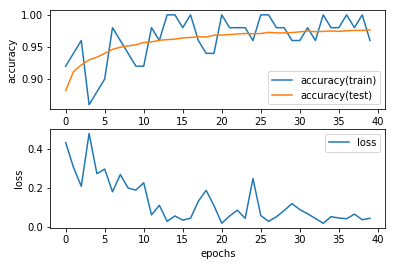

In [8]:
import matplotlib.pyplot as plt

x = range(n_epochs)
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(x, train_acc_vec, label="accuracy(train)")
ax1.plot(x, test_acc_vec, label="accuracy(test)")
ax1.legend() #loc="upper right")
ax1.set_ylabel("accuracy")

ax2 = fig.add_subplot(2,1,2)
ax2.plot(x, loss_vec, label="loss")
ax2.legend() #loc="upper right")
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")

plt.show()